In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import logging
import os
from typing import Optional

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hintrospection as hintros
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import helpers.hs3 as hs3
import oms as oms

In [22]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4784_add_s3_support_to_oms_get_target_dir'
  hash='6d2d4ddd5'
  # Last commits:
    *   6d2d4ddd5 Samarth  Merge branch 'CmTask4784_add_s3_support_to_oms_get_target_dir' of github.com:cryptokaizen/cmamp into CmTask4784_add_s3_support_to_oms_get_target_dir (12 minutes ago) Mon Jul 17 17:26:37 2023  (HEAD -> CmTask4784_add_s3_support_to_oms_get_target_dir, origin/CmTask4784_add_s3_support_to_oms_get_target_dir)
    |\  
    * | 089b89f99 Samarth  update with error                                                 (12 minutes ago) Mon Jul 17 17:26:28 2023           
    | * 677

# Build the reconciliation config

In [30]:
# Get config from env when running the notebook via the `run_notebook.py` script, e.g.,
# in the system reconciliation flow.
config = cconfig.get_config_from_env()
#
if config:
    _LOG.info("Using config from env vars")
else:
    _LOG.info("Using hardwired config")
    # Specify the config directly when running the notebook manually.
    # Below is just an example.
    prod_data_root_dir = "/shared_data/ecs/preprod/system_reconciliation"
    dag_builder_name = "C3a"
    run_mode = "paper_trading"
    start_timestamp_as_str = "20230716_131000"
    end_timestamp_as_str = "20230717_130500"
    mode = "scheduled"
    save_plots_for_investors = True
    html_bucket_path = henv.execute_repo_config_code("get_html_bucket_path()")
    s3_dst_dir = os.path.join(html_bucket_path, "pnl_for_investors")
    config_list = oms.build_prod_pnl_real_time_observer_configs(
        prod_data_root_dir,
        dag_builder_name,
        run_mode,
        start_timestamp_as_str,
        end_timestamp_as_str,
        mode,
        save_plots_for_investors,
        s3_dst_dir=s3_dst_dir,
    )
    config = config_list[0]
print(config)

INFO  Using hardwired config
INFO  run_date='20230716'
INFO  Using run_date=20230716
INFO  dst_root_dir='/shared_data/ecs/preprod/system_reconciliation', dag_builder_name='C3a', run_mode='paper_trading', start_timestamp_as_str='20230716_131000', end_timestamp_as_str='20230717_130500'
INFO  target_dir='/shared_data/ecs/preprod/system_reconciliation/C3a/paper_trading/20230716_131000.20230717_130500'
INFO  system_log_dir='system_log_dir.scheduled'
meta: 
  dag_builder_name: C3a
  date_str: 20230716
  bar_duration: 5T
  save_plots_for_investors: True
s3_dst_dir: s3://cryptokaizen-html/pnl_for_investors
system_log_dir: /shared_data/ecs/preprod/system_reconciliation/C3a/paper_trading/20230716_131000.20230717_130500/system_log_dir.scheduled
system_config_func_as_str: dataflow_orange.system.Cx.get_Cx_system_config_template_instance('C3a')
research_forecast_evaluator_from_prices: 
  init: 
    price_col: vwap
    prediction_col: feature
    volatility_col: garman_klass_vol
  annotate_forecasts_

# Specify data to load

In [31]:
# Points to `system_log_dir/dag/node_io/node_io.data`.
data_type = "dag_data"
dag_data_path = oms.get_data_type_system_log_path(
    config["system_log_dir"], data_type
)
_LOG.info("dag_data_path=%s", dag_data_path)
# Points to `system_log_dir/dag/node_io/node_io.prof`.
data_type = "dag_stats"
dag_info_path = oms.get_data_type_system_log_path(
    config["system_log_dir"], data_type
)
_LOG.info("dag_info_path=%s", dag_info_path)
# Points to `system_log_dir/process_forecasts/portfolio`.
data_type = "portfolio"
portfolio_path = oms.get_data_type_system_log_path(
    config["system_log_dir"], data_type
)
_LOG.info("portfolio_path=%s", portfolio_path)
# Points to `system_log_dir/process_forecasts/orders`.
data_type = "orders"
orders_path = oms.get_data_type_system_log_path(
    config["system_log_dir"], data_type
)
_LOG.info("orders_path=%s", orders_path)

INFO  dag_data_path=/shared_data/ecs/preprod/system_reconciliation/C3a/paper_trading/20230716_131000.20230717_130500/system_log_dir.scheduled/dag/node_io/node_io.data
INFO  dag_info_path=/shared_data/ecs/preprod/system_reconciliation/C3a/paper_trading/20230716_131000.20230717_130500/system_log_dir.scheduled/dag/node_io/node_io.prof
INFO  portfolio_path=/shared_data/ecs/preprod/system_reconciliation/C3a/paper_trading/20230716_131000.20230717_130500/system_log_dir.scheduled/process_forecasts/portfolio
INFO  orders_path=/shared_data/ecs/preprod/system_reconciliation/C3a/paper_trading/20230716_131000.20230717_130500/system_log_dir.scheduled/process_forecasts/orders


# System config

In [32]:
# TODO(Grisha): Load the system config as df instead of just printing the DAG config.
system_config = hintros.get_function_from_string(
    config["system_config_func_as_str"]
)
print(system_config)

dag_config: 
  compute_bar_feature: 
    in_col_groups: [('close',), ('high',), ('low',)]
    out_col_group: ()
    transformer_kwargs: 
      close_col: close
      high_col: high
      low_col: low
    drop_nans: True
  resample: 
    in_col_groups: [('close',), ('high',), ('low',), ('open',), ('stochastic',), ('volume',)]
    out_col_group: ()
    transformer_kwargs: 
      rule: 5T
      resampling_groups: [({'close': 'close'}, 'last', {}), ({'high': 'high'}, 'max', {}), ({'low': 'low'}, 'min', {}), ({'open': 'open'}, 'first', {}), ({'volume': 'volume'}, 'sum', {'min_count': 1}), ({'close': 'twap'}, 'mean', {})]
      vwap_groups: [('close', 'volume', 'vwap'), ('stochastic', 'volume', 'cmf')]
    reindex_like_input: False
    join_output_with_input: False
  compute_vol: 
    in_col_groups: [('close',), ('high',), ('low',), ('open',)]
    out_col_group: ()
    transformer_kwargs: 
      estimators: ['close', 'parkinson', 'garman_klass']
      open_col: open
      high_col: high
    

# DAG io

## Load

In [33]:
# Get DAG node names.
dag_node_names = oms.get_dag_node_names(dag_data_path)
_LOG.info(
    "First node='%s' / Last node='%s'", dag_node_names[0], dag_node_names[-1]
)

INFO  First node='predict.0.read_data' / Last node='predict.5.process_forecasts'


In [34]:
# Get timestamps for the last DAG node.
dag_node_timestamps = oms.get_dag_node_timestamps(
    dag_data_path, dag_node_names[-1], as_timestamp=True
)
_LOG.info(
    "First timestamp='%s'/ Last timestamp='%s'",
    dag_node_timestamps[0][0],
    dag_node_timestamps[-1][0],
)

INFO  First timestamp='2023-07-16 09:10:00-04:00'/ Last timestamp='2023-07-17 09:05:00-04:00'


In [36]:
# Get DAG output for the last node and the last timestamp.
dag_df_prod = oms.load_dag_outputs(dag_data_path, dag_node_names[-1])
_LOG.info("Output of last node:")
hpandas.df_to_str(dag_df_prod, num_rows=5, log_level=logging.INFO)

INFO  Output of last node:


feature                                                                                                                                                                                                                                                                          close_vol                                                                                                                                                                                                                                                                         garman_klass_vol                                                                                                                                                                                                                                                                         parkinson_vol                                                                                                                                                                                                                                                                              close                                                                                                                                                                                                                                                                                cmf                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                                                                                                                                                               twap                                                                                                                                                                                                                                                                              volume                                                                                                                                                                                                                                                                                 vwap                                                                                                                                                                                                                                                                              
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384

## Compute DAG execution time

In [37]:
df_dag_execution_time = oms.get_execution_time_for_all_dag_nodes(dag_data_path)
_LOG.info("DAG execution time:")
hpandas.df_to_str(df_dag_execution_time, num_rows=5, log_level=logging.INFO)

INFO  DAG execution time:


,all_nodes,read_data,compute_bar_feature,resample,compute_vol,generate_feature,process_forecasts
2023-07-16 09:10:00-04:00,6.235,0.896,1.209,1.407,0.989,0.879,0.855
2023-07-16 09:15:00-04:00,6.113,0.874,1.171,1.392,0.966,0.871,0.839
,...,...,...,...,...,...,...
2023-07-17 09:00:00-04:00,8.749,0.867,1.708,1.891,1.51,1.397,1.376
2023-07-17 09:05:00-04:00,8.772,0.882,1.693,1.898,1.506,1.41,1.383


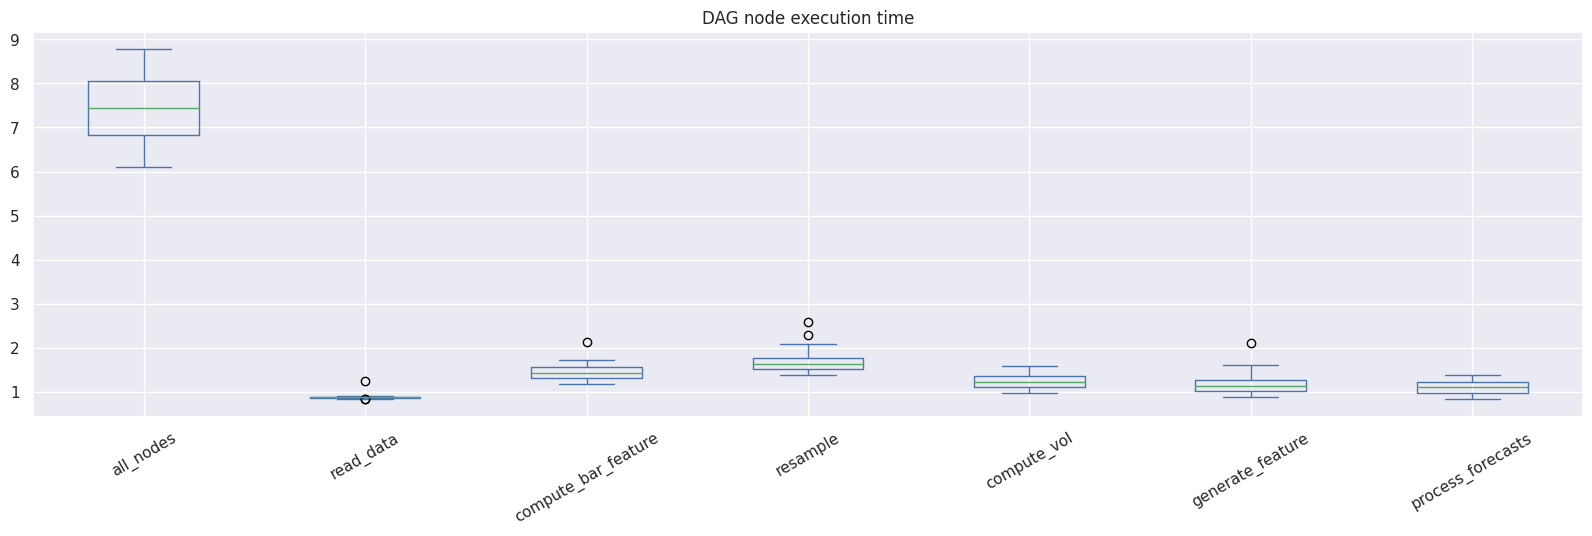

In [38]:
oms.plot_dag_execution_stats(df_dag_execution_time, report_stats=False)

In [39]:
# The time is an approximation of how long it takes to process a bar. Technically the time
# is a distance (in secs) between wall clock time when an order is executed and a bar
# timestamp. The assumption is that order execution is the very last stage.
df_order_execution_time = oms.get_orders_execution_time(orders_path)
# TODO(Grisha): consider adding an assertion that checks that the time does not
# exceed one minute.
_LOG.info(
    "Max order execution time=%s secs",
    df_order_execution_time["execution_time"].max(),
)

INFO  Max order execution time=35 secs


# Portfolio

## Compute research portfolio equivalent

In [40]:
# Set Portofolio start and end timestamps.
start_timestamp = dag_node_timestamps[0][0]
end_timestamp = dag_node_timestamps[-1][0]
_LOG.info("start_timestamp=%s", start_timestamp)
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2023-07-16 09:10:00-04:00
INFO  end_timestamp=2023-07-17 09:05:00-04:00


In [41]:
fep = dtfmod.ForecastEvaluatorFromPrices(
    **config["research_forecast_evaluator_from_prices"]["init"]
)
annotate_forecasts_kwargs = config["research_forecast_evaluator_from_prices"][
    "annotate_forecasts_kwargs"
].to_dict()
research_portfolio_df, research_portfolio_stats_df = fep.annotate_forecasts(
    dag_df_prod,
    **annotate_forecasts_kwargs,
    compute_extended_stats=True,
)
# TODO(gp): Move it to annotate_forecasts?
research_portfolio_df = research_portfolio_df.sort_index(axis=1)
# Align index with prod portfolio.
research_portfolio_df = research_portfolio_df.loc[start_timestamp:end_timestamp]
research_portfolio_stats_df = research_portfolio_stats_df.loc[
    start_timestamp:end_timestamp
]
#
hpandas.df_to_str(research_portfolio_stats_df, num_rows=5, log_level=logging.INFO)

/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1001) is greater than the total number of samples (25). n_quantiles is set to n_samples.
  warnings.warn(


,pnl,gross_volume,net_volume,gmv,nmv,gpc,npc,wnl
2023-07-16 09:25:00-04:00,0.164503,5137.952654,1637.423553,3018.405424,1589.52688,24.0,0.0,0.0
2023-07-16 09:30:00-04:00,0.648512,4312.025484,-827.090629,2995.101845,763.084762,23.0,1.0,-1.0
,...,...,...,...,...,...,...,...
2023-07-17 09:00:00-04:00,-0.975649,3795.495396,-874.64528,2994.531078,-1418.341567,24.0,0.0,0.0
2023-07-17 09:05:00-04:00,-0.229379,3547.626276,1896.468991,2998.101412,477.898046,24.0,0.0,2.0


## Load logged portfolios (prod & research)

In [42]:
portfolio_dfs, portfolio_stats_dfs = oms.load_portfolio_dfs(
    {"prod": portfolio_path},
    config["meta"]["bar_duration"],
)
# Add research portfolio.
portfolio_dfs["research"] = research_portfolio_df
hpandas.df_to_str(portfolio_dfs["prod"], num_rows=5, log_level=logging.INFO)

INFO  Processing portfolio=prod path=/shared_data/ecs/preprod/system_reconciliation/C3a/paper_trading/20230716_131000.20230717_130500/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

holdings_shares                                                                                                                                                                                                                                                                         holdings_notional                                                                                                                                                                                                                                                                             executed_trades_shares                                                                                                                                                                                                                                                                         executed_trades_notional                                                                                                                                                                                                                                                                                   pnl                                                                                                                                                                                                                                                                        
                               6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 2476706208 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986        1030828978  1464553467  1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510  2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052  3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573             6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 2476706208 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986               8717633868 2540896331 1528092593 8968126878  1467591036 2476706208 3065029174 1891737434  1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2425308589 1776791608  2384892553 2237530510 3401245610 5115052901 5118394986 6051632686 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
2023-07-16 09:10:00-04:00             0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0               0.0         0.0         0.0        0.0        0.0        0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0                    0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0                      NaN        NaN        NaN        NaN         NaN        NaN        NaN        NaN         NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN        NaN        

In [43]:
# Add research df and combine into a single df.
portfolio_stats_dfs["research"] = research_portfolio_stats_df
portfolio_stats_df = pd.concat(portfolio_stats_dfs, axis=1)
#
hpandas.df_to_str(portfolio_stats_df, num_rows=5, log_level=logging.INFO)

prod                                                                                        research                                                                    
                                pnl gross_volume   net_volume          gmv          nmv        cash  net_wealth  leverage       pnl gross_volume   net_volume          gmv          nmv   gpc  npc  wnl
2023-07-16 09:10:00-04:00       NaN          0.0          0.0          0.0          0.0       700.0       700.0       0.0       NaN          NaN          NaN          NaN          NaN   NaN  NaN  NaN
2023-07-16 09:15:00-04:00       0.0  2977.291636    2234.4357  2977.291636    2234.4357  -1534.4357       700.0  4.253274       NaN          NaN          NaN          NaN          NaN   NaN  NaN  NaN
                                ...          ...          ...          ...          ...         ...         ...       ...       ...          ...          ...          ...          ...   ...  ...  ...
2023-07-17 09:00:00-04:00 -1.004256  3783.916854  -860.853482  2996.915304 -1416.262808  2120.20545  703.942642  4.257329 -0.975649  3795.495396   -874.64528  2994.531078 -1418.341567  24.0  0.0  0.0
2023-07-17 09:05:00-04:00 -0.103174  3533.039572  1877.665236  2994.813786   461.228374  242.540214  703.768588  4.255396 -0.229379  3547.626276  1896.468991  2998.101412   477.898046  24.0  0.0  2.0

## Compute Portfolio statistics (prod vs research)

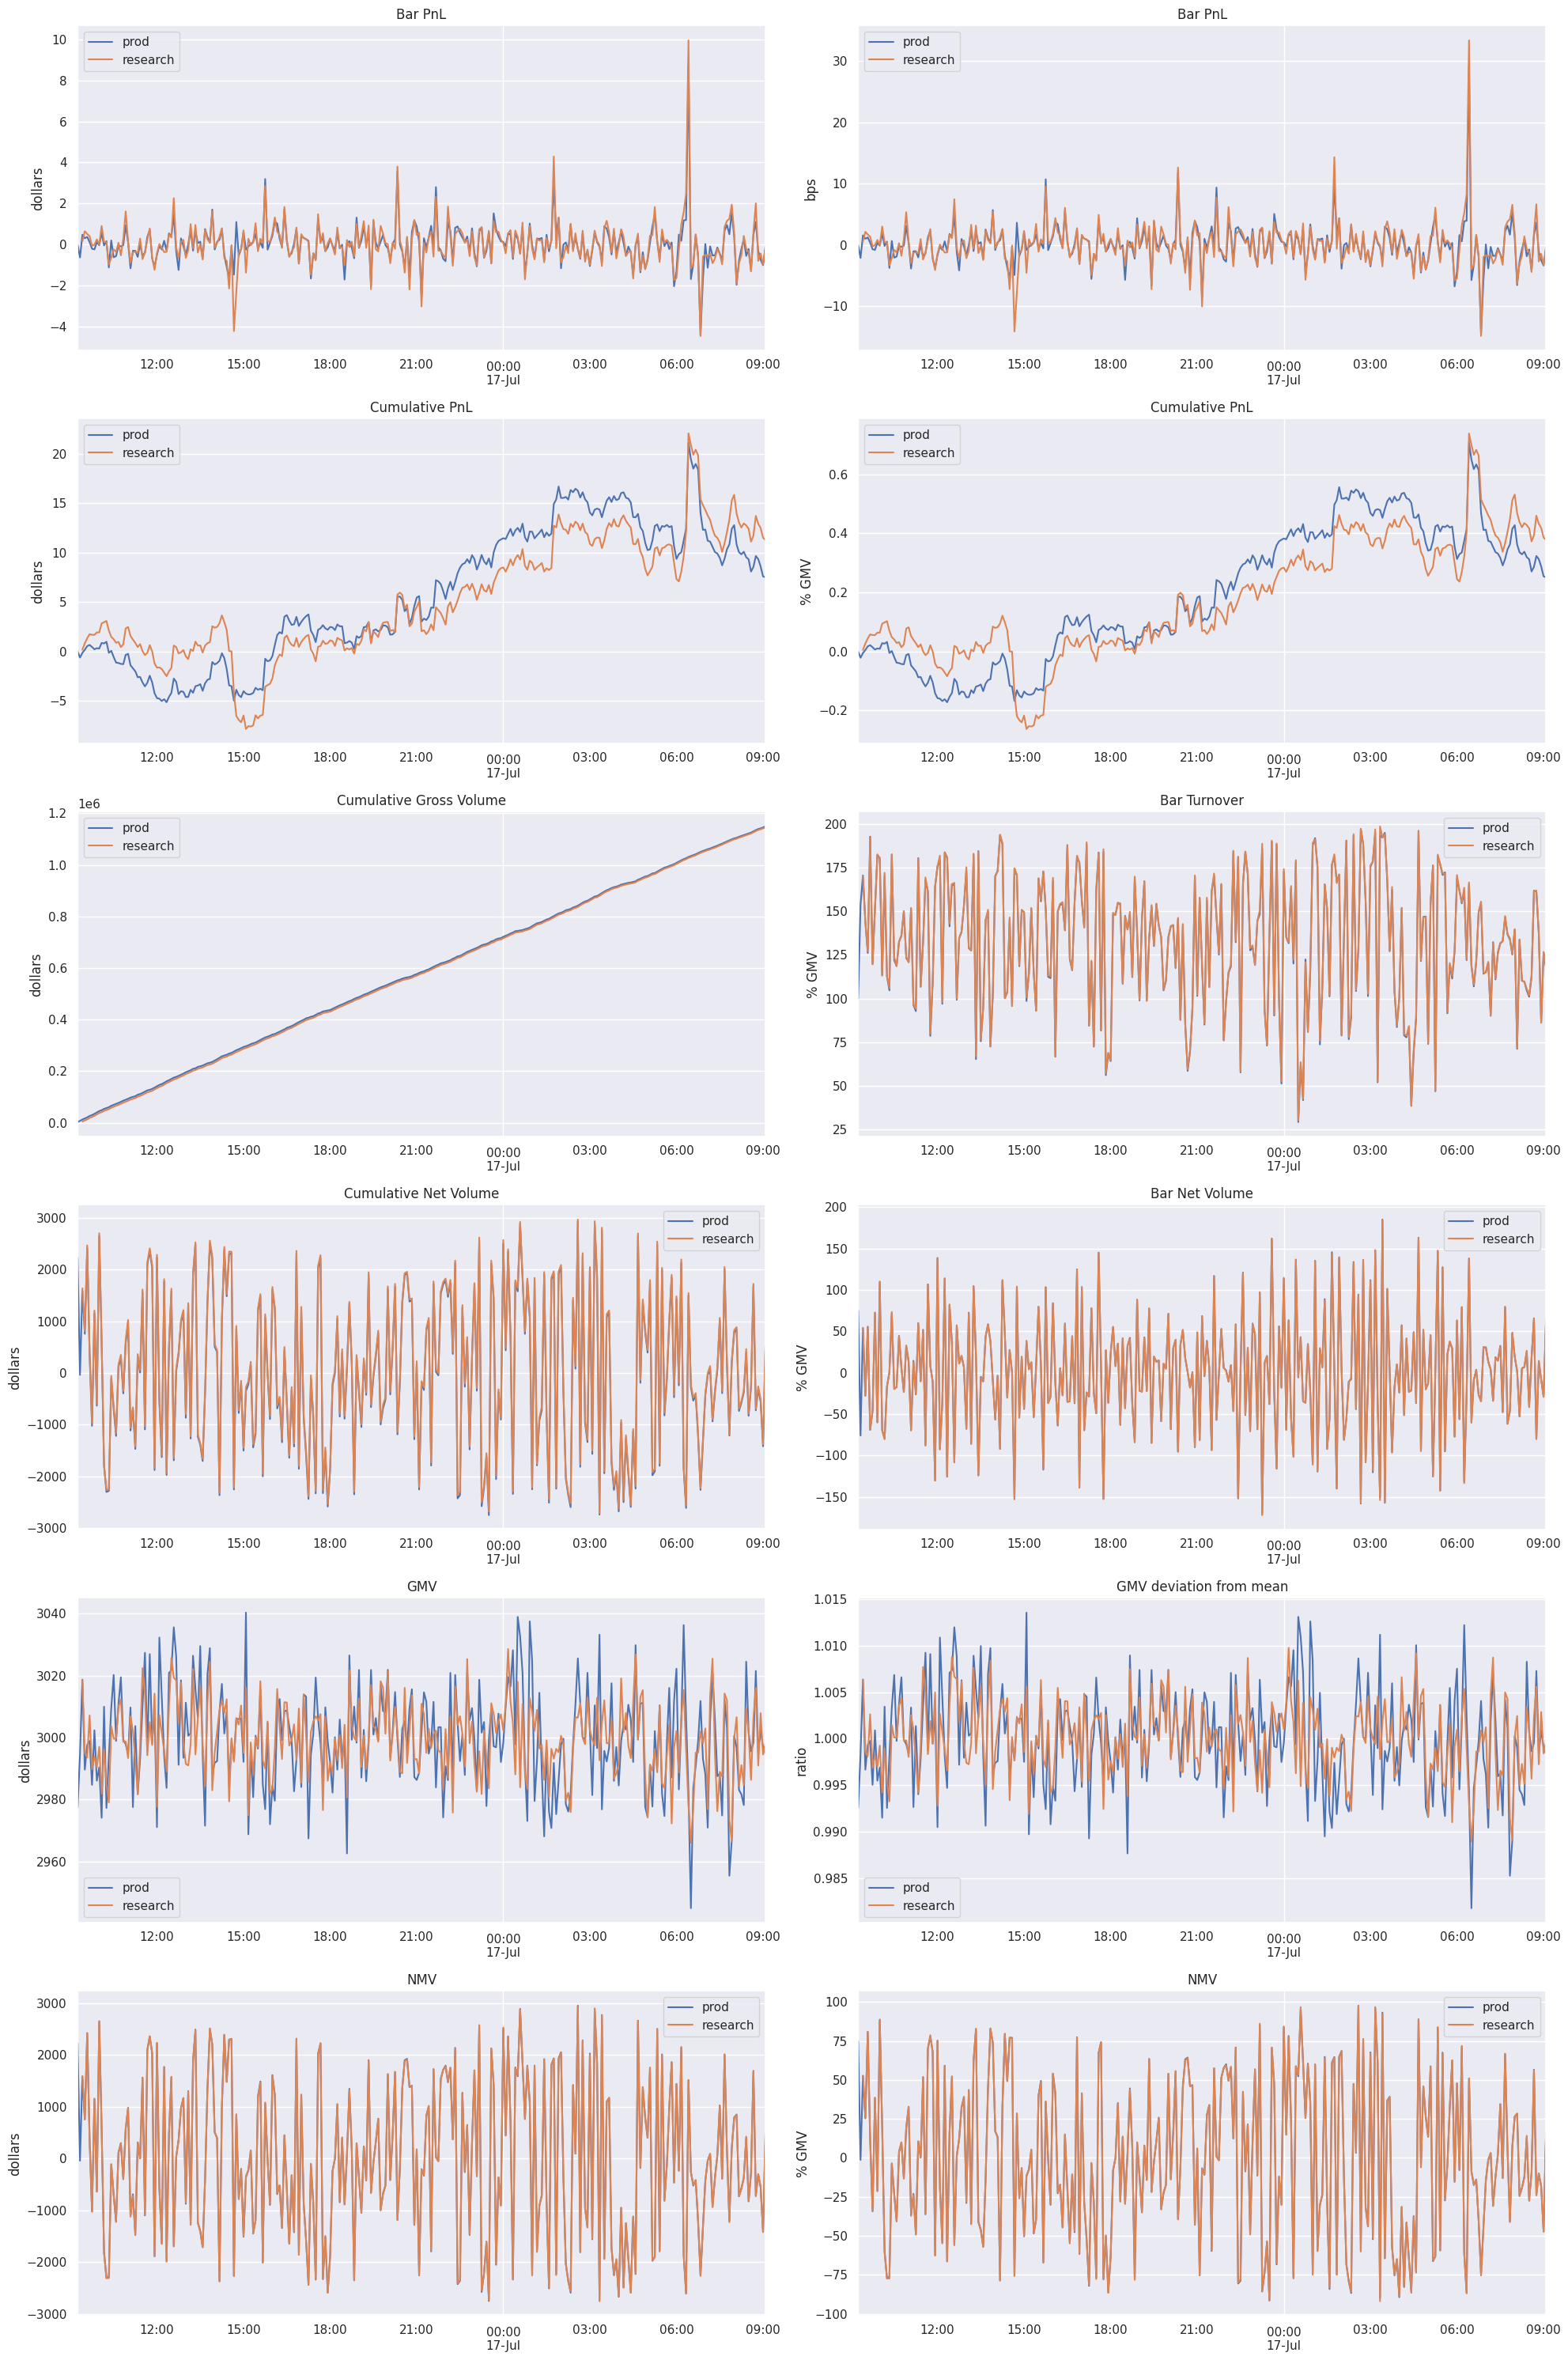

In [44]:
bars_to_burn = 1
coplotti.plot_portfolio_stats(portfolio_stats_df.iloc[bars_to_burn:])

In [45]:
stats_computer = dtfmod.StatsComputer()
stats_sxs, _ = stats_computer.compute_portfolio_stats(
    portfolio_stats_df.iloc[bars_to_burn:], config["meta"]["bar_duration"]
)
display(stats_sxs)

prod  research
ratios     sharpe_ratio                    8.57     11.34
           sharpe_ratio_standard_error    19.18     19.18
           sr.tval                         0.45      0.59
           sr.pval                         0.65      0.55
           kratio                         34.45     31.84
dollar     gmv_mean                     2999.67   2999.30
           gmv_stdev                      16.01     11.88
           annualized_mean_return       2744.39   4132.41
           annualized_volatility         320.12    364.39
           max_drawdown                   13.65     12.00
           pnl_mean                        0.03      0.04
           pnl_std                         0.99      1.13
           turnover_mean                4003.78   4019.70
           turnover_stdev               1127.84   1128.44
           market_bias_mean               12.87      6.13
           market_bias_stdev            1515.98   1514.82
percentage annualized_mean_return         91.49    137.78
           annualized_volatility          10.67     12.15
           max_drawdown                    0.46      0.40
           pnl_mean                        0.00      0.00
           pnl_std                         0.03      0.04
           turnover_mean                 133.47    134.02
           turnover_stdev                 37.60     37.62
           market_bias_mean                0.43      0.20
           market_bias_stdev              50.54     50.51

# PnL for investors

In [46]:
# TODO(Grisha): move to a lib.
def adjust_matplotlib_settings() -> None:
    """
    Adjust the Matplotlib settings for readability.
    """
    # Matplotlib setting to make the plots readable in presentations.
    matplotlib.rcParams.update({"font.size": 22})
    #
    BIG_SIZE = 22
    #
    plt.rc("font", size=BIG_SIZE)  # controls default text sizes
    plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
    plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
    plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
    plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title
    #
    matplotlib.rcParams["figure.dpi"] = 300


# TODO(Grisha): move to a lib.
def plot_cumulative_pnl(
    cumul_pnl: pd.Series,
    plot_title: str,
    *,
    save_to_tmp_file: bool = True,
    copy_to_s3: bool = True,
    s3_dst_file_path: Optional[str] = None,
) -> None:
    """
    Plot cumulative PnL.

    :param cumul_pnl: cumulative PnL
    :param plot_title: title for the plot
    :param save_to_tmp_file: save the plot locally to a tmp file if True,
        proceed otherwise
    :param copy_to_s3: copy to the saved plot to S3 if True, proceed otherwise
    :param s3_dst_file_path: path on S3 to copy the saved plot to, e.g.,
        `s3://.../system_reconciliation/test_image.png`
    """
    adjust_matplotlib_settings()
    # TODO(Grisha): set `target_gmv` properly instead.
    cumul_pnl = cumul_pnl * 1000
    ax = cumul_pnl.plot(title=plot_title)
    # Set the labels formatting, e.g., `1000.0` -> `$1,000`.
    ax.yaxis.set_major_formatter("${x:,.0f}")
    if save_to_tmp_file:
        # Save the plot locally to a tmp file.
        tmp_file_path = "/app/tmp.png"
        _LOG.info("Saving the PnL plot to %s", tmp_file_path)
        plt.savefig(tmp_file_path, bbox_inches="tight")
        if copy_to_s3:
            # Copy a tmp file to S3.
            aws_profile = "ck"
            hs3.copy_file_to_s3(tmp_file_path, s3_dst_file_path, aws_profile)
    # Saving must precede `show()`.
    plt.show()

INFO  Saving the PnL plot to /app/tmp.png
INFO  Copying from /app/tmp.png to s3://cryptokaizen-html/test/cumulative_pnl.last_24hours.png
upload: ../../../tmp.png to s3://cryptokaizen-html/test/cumulative_pnl.last_24hours.png


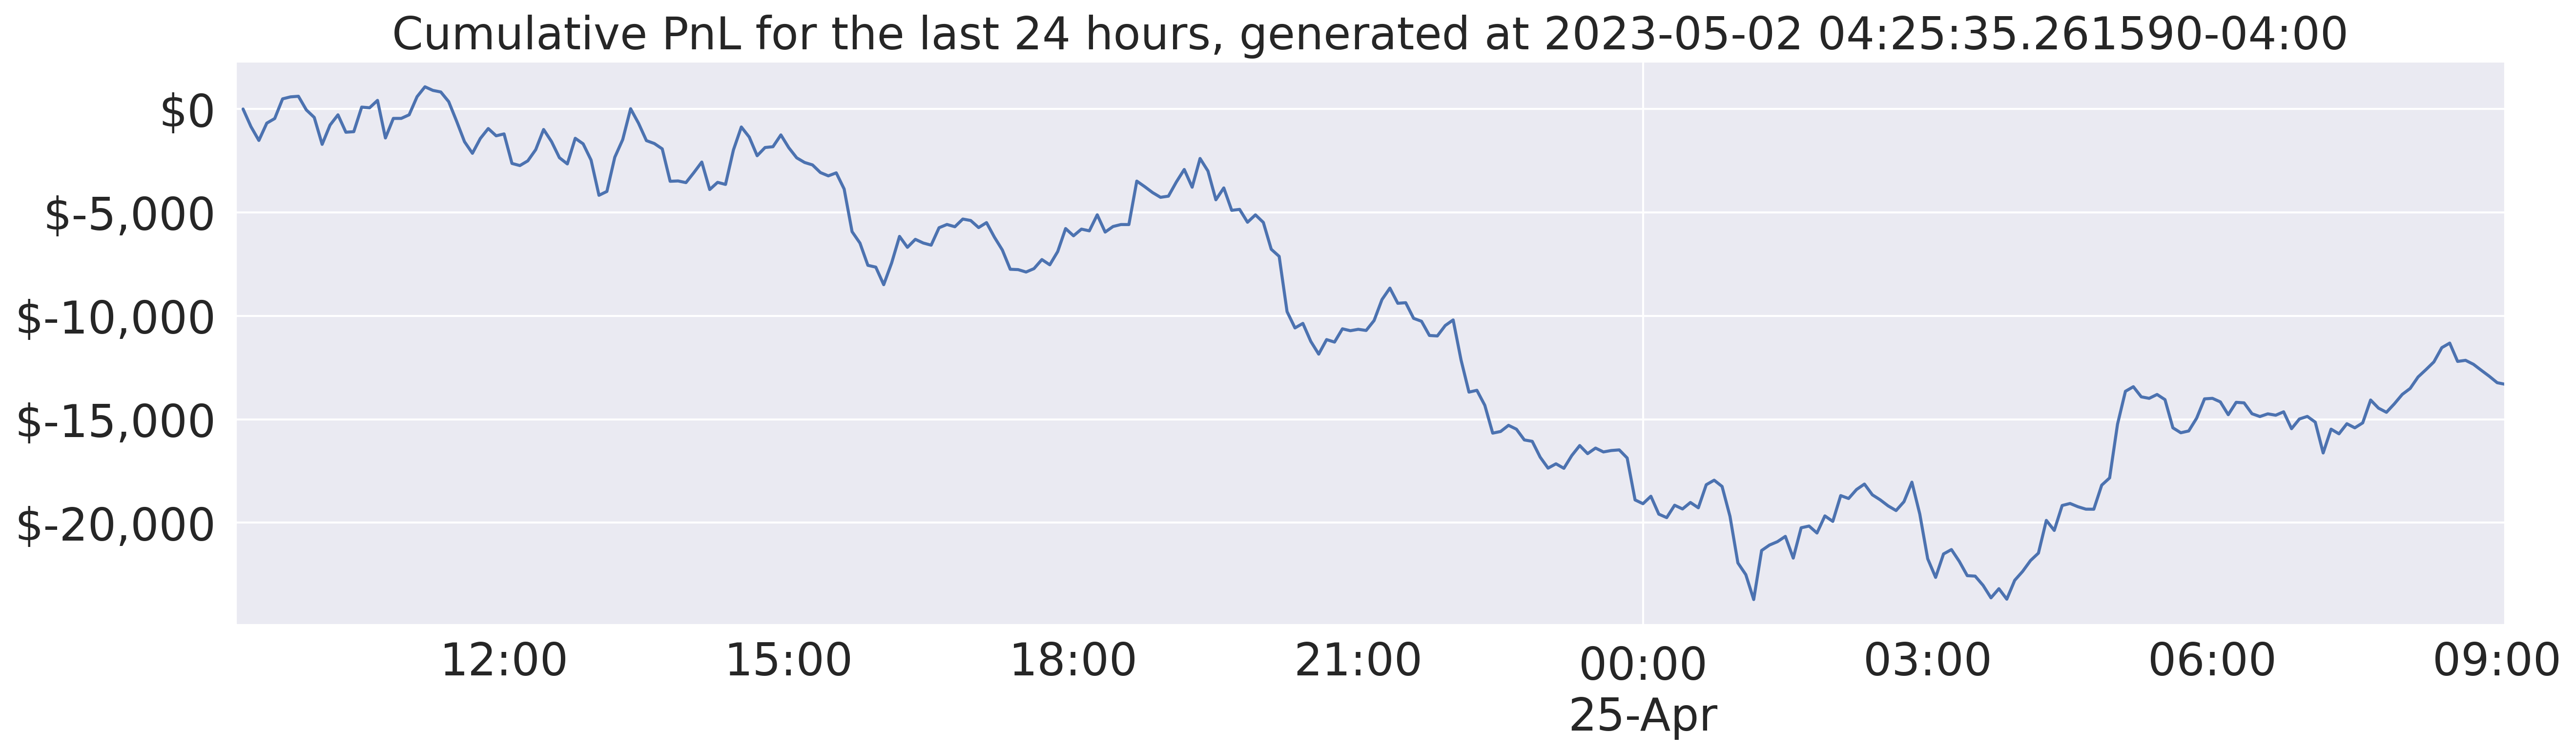

In [24]:
# Save the plots only for C3a.
if (
    config["meta"]["dag_builder_name"] == "C3a"
    and config["meta"]["save_plots_for_investors"]
):
    pnl_df = portfolio_stats_df["prod"]
    # Get the number of hours for which the system is run.
    bar_duration_in_minutes = int(config["meta"]["bar_duration"].rstrip("T"))
    pnl_num_hours = pnl_df.shape[0] * bar_duration_in_minutes / 60
    # Verify that the number of hours is in [0,24] range.
    hdbg.dassert_lgt(
        0,
        pnl_num_hours,
        24,
        lower_bound_closed=False,
        upper_bound_closed=True,
    )
    # TODO(Grisha): this is a hack. Ideally we should schedule a DAG
    # after the prod run is finished to get a plot for 24 hours.
    current_et_time = hdateti.get_current_time("ET")
    if round(pnl_num_hours) == 24:
        # A 24 hours run is a complete run so save as the last 24 hours results.
        file_name = "cumulative_pnl.last_24hours.png"
        plot_title = f"Cumulative PnL for the last 24 hours, generated at {current_et_time}"
    else:
        # If a run is not complete save as last 5 minutes results.
        file_name = "cumulative_pnl.last_5minutes.png"
        plot_title = f"Cumulative PnL for the last 5 minutes, generated at {current_et_time}"
    cumul_pnl = pnl_df["pnl"].cumsum()
    s3_dst_path = os.path.join(config["s3_dst_dir"], file_name)
    save_to_tmp_file = True
    copy_to_s3 = True
    plot_cumulative_pnl(
        cumul_pnl,
        plot_title,
        save_to_tmp_file=save_to_tmp_file,
        copy_to_s3=copy_to_s3,
        s3_dst_file_path=s3_dst_path,
    )